# Credit Card Fraud Detection

## About

Credit card fraud detection is a real world problem that is plaguing the nations. It is an anomaly detection problem due to the Poisson distributed positive cases. Fraud doesn't happen every day, but when it does happen, we want to capture it and predict, given the types of patterns that we can detect, which accounts will likely experience an instance of fraudulent activity.

Being able to work with fraud detection gives us insight into working with all sorts of anomaly detection type problems in the feature, even outside this particular domain.

## The Dataset

The dataset was retrieved from data world, which retrieved it from a Kaggle competitition. It's a flat datset and not necessarily considered big data, however, it will serve its purpose here. 

The attributes for the dataset, for the most part, were stripped so we don't really have a human readable understanding of what the attributes mean, but from what I can tell, the values for each of these anonymized attributes are normalized values.

Our target is a boolean, indicating whether or not the account has experienced fraudulent activity or not.


## Download External Dependencies

In [0]:
!pip install pyod
!pip install imbalance-learn

     |████████████████████████████████| 92kB 3.1MB/s 
  Created wheel for pyod: filename=pyod-0.7.5-cp36-none-any.whl size=96597 sha256=329b41a995acb4f35e31a47727e10ac9acd0c4e21ee5c7eadef928d6e93f32c5
  Stored in directory: /root/.cache/pip/wheels/35/bc/f4/2cef321eac851ba02f533e3921b296bb4ce4998c8a4c9a8d6e
Successfully built pyod
ERROR: Could not find a version that satisfies the requirement imbalance-learn (from versions: none)
ERROR: No matching distribution found for imbalance-learn


## Load Dependencies

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from inspect import signature
%matplotlib inline
import pandas as pd
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)

from google.colab import drive
import pandas_profiling
from timeit import default_timer
from sklearn.metrics import (precision_score, confusion_matrix, recall_score, accuracy_score, 
                             balanced_accuracy_score,roc_auc_score, classification_report, confusion_matrix, 
                             r2_score, f1_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import SGDClassifier

## Constants

In [0]:
DRIVENAME = "/content/drive/"
FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/scaled_and_processed_cc.csv"

## Functions

In [0]:
def mount_drive(drivename):
    from google.colab import drive
    drive.mount(drivename)


def load_csv_file(path):
    dataframe = pd.read_csv(FILENAME)
    if isinstance(dataframe["Unnamed: 0"], pd.Series):
        dataframe = dataframe.drop('Unnamed: 0', inplace=False, axis=1)
    return dataframe


def drop_features(dataframe, cols):
    for col in cols:
        dataframe.drop(col, axis=1, inplace=True)
    return dataframe


def rename_target(dataframe, label):
    return dataframe.rename({label: "target"}, axis=1, inplace=False)


def remap_boolean(dataframe, label):
    return dataframe[label].replace({False:0, True:1}, inplace=False)


def scale_feature(dataframe, label):
    return dataframe[label].apply(lambda x: (x-dataframe[label].mean())/dataframe[label].std())


def preprocess(dataframe, cols_to_drop, cols_to_remap, cols_scale):
    start_time = default_timer()
    dataframe = drop_features(dataframe, cols_to_drop)
    dataframe = rename_target(dataframe, "class")
    dataframe[cols_to_remap] = remap_boolean(dataframe, cols_to_remap)
    dataframe[cols_scale] = scale_feature(dataframe, cols_scale)
    end_time = default_timer()
    print(f"Processing completed. Elapsed time: {end_time-start_time}")
    return dataframe


def split_data_into_feature_and_target(data, target_label="target"):
    """ Splits the dataframe into features and target
    :param data: is dataframe with last column on right as target
    """
    X = data.loc[:, data.columns != target_label].values
    y = data[target_label].values
    return X, y


def plot_pca(X, y, list_n_pca_components):
    """ plots a PCA plot... borrowed code that I want to touch as little as possible """
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier
    from timeit import default_timer

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                            max_iter=100, tol=1e-5, random_state=0)
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'pca__n_components': list_n_pca_components,
        'logistic__alpha': np.logspace(-4, 4, 5),
    }

    start_time = default_timer()
    search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    # Plot the PCA spectrum
    pca.fit(X)
    end_time = default_timer()
    print("Elapsed time to fit: {}s".format(end_time - start_time))
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(pca.explained_variance_ratio_, linewidth=2)
    ax0.set_ylabel('PCA explained variance')

    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, 'mean_test_score'))

    best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                legend=False, ax=ax1)
    ax1.set_ylabel('Classification accuracy (val)')
    ax1.set_xlabel('n_components')

    plt.tight_layout()
    plt.show()


def extract_pc_into_df(data, n_pca_components):
    from sklearn.linear_model import SGDClassifier
    from sklearn.decomposition import PCA

    X, y = split_data_into_feature_and_target(data)

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0, alpha=0.0001)
    
    pca = PCA(n_components=n_pca_components)
    principal_components = pca.fit_transform(X, y)

    princ_comp_names = [f"pc{a}" for a in range(1, 12)]
    dataframe = pd.DataFrame(principal_components, columns=princ_comp_names)
    dataframe['target'] = data['target'].values

    return dataframe


def normality_of_distribution_test(feature, significance_level=0.05):
    from scipy.stats import normaltest
    test_normality = normaltest(feature, axis=0, nan_policy='propagate')
    if test_normality[1]<significance_level:
        print("This feature is normally distributed about the mean")
    else:
        print("This feature is NOT normally distributed about the mean")


def fit_simple_model(data, model_type):
    from timeit import default_timer
    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if model_type == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
    else:
        raise ValueError("Please select a valid model_type value")
    
    start_time = default_timer()
    fitted_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Model fitting and prediction complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time


def fit_get_predictions_with_CV(data, model_name, param_search_space):
    """ Uses the GridSearchCV to fit specified model. 
    param_search_space must be compatible with models passed in """
    from timeit import default_timer

    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    if model_name == "RFC":
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier()
    
    elif model_name == "logistic regression":
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression(class_weight="balanced", verbose=0, random_state=42, 
                                       max_iter=100, solver="saga", warm_start=False, n_jobs=-1, 
                                       l1_ratio=1)
        
    elif model_name == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        estimator = GaussianNB()

    elif model_name == "KNN":
        from sklearn.neighbors import KNeighborsClassifier
        estimator = KNeighborsClassifier()
    
    else:
        raise ValueError("Please enter a valid model_name string value")

    start_time = default_timer()
    gscv = GridSearchCV(estimator, param_search_space, cv=10, error_score="raise")
    fitted_model = gscv.fit(X_train, y_train)
    y_pred = gscv.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Training, Validation and Testing are complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time


def conf_mat_parser(confusion_matrix):
    """ parse a confusion matrix into its components """""""""""
    TN, FN, FP, TP = [i for j in confusion_matrix for i in j]
    return TN, FN, FP, TP


def detailed_confusion_matrix(y_test, y_pred):
    """ prints out confusion matrix with more labeling and detail """

    TN, FP, FN, TP = conf_mat_parser(confusion_matrix(y_test, y_pred))
    sensitivity = (TP/(TP+FN))
    specificity = (TN/(TN+FP))
    precision = (TP / (TP+FP))

    print("                           *Fraudulent Cases are considered Positive Cases")
    print("============================================================================================")
    print("######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########")
    print("\n")
    print(f"Actually Non-Fraudulent | TN = {TN}                   | FP = {FP}")
    print("\n")
    print(f"Actually Fraudulent     | FN = {FN}                       | TP = {TP} ")
    print("\n")
    print(f"Specificity: {sensitivity}")
    print(f"Sensitivity (aka. Recall): {specificity}")


def report_performance_scores(model, y_test, y_pred, train_time):
    """ prints out some of the useful performance metrics of our model as well as returns a dataframe containing those metrics """
    from sklearn.metrics import (classification_report, confusion_matrix, 
                                 recall_score, precision_score, roc_auc_score,
                                 accuracy_score, r2_score, f1_score
                                 )
    dataframe = pd.DataFrame({"id":["000"], 
        "best_parameters":f"{model.get_params}", 
        "accuracy":[accuracy_score(y_test, y_pred)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[r2_score(y_test, y_pred)],
        "f1-score": [f1_score(y_test, y_pred)],
        "train_time(s)":f"{train_time}"
        })
    
    pp.pprint(classification_report(y_test, y_pred))
    print("\n")
    print(f"ROC Score: {roc_auc_score(y_test, y_pred)}")
    print("\n")
    detailed_confusion_matrix(y_test, y_pred)
    return dataframe

def get_max_probas(y_pred_probs):
    """ get array of target probabilities and return an array of 
    prediicted max probabilities for a binary class problem """
    df = pd.DataFrame(y_pred_probs)
    df['max'] = df.max(axis=1)
    y_pred_probs_max = df['max'].values
    return y_pred_probs_max

def predict_max_prob(model, X_test):
    y_pred_probs = model.predict_proba(X_test)
    y_pred_probs_max = get_max_probas(y_pred_probs)
    return y_pred_probs_max

def plot_roc(y_test, y_pred_probs, n_classes=2):
    """ make sure that y_pred are probabilities """
    from sklearn.metrics import roc_curve, auc


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operator Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_prc(y_test, y_pred_probs, y_pred):
    
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
    plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
    

def sample_for_test_set(dataframe, target="target", fraction=0.3, include_minority=True):
    """ resample dataframe """
    if include_minority:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.sample(frac=0.3, replace=False), columns=dataframe.columns).reset_index()                         
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    else:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.loc[dataframe[target] == 0, :].sample(frac=0.3, replace=False), 
                                                columns=dataframe.columns).reset_index()
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    return X_test, y_test


def  get_outlier_scores(X_train, X_test):
    """ returns outlier test scores for anomalous data points """
    from pyod.models.knn import KNN
    clf = KNN()
    clf.fit(X_train)

    # get outlier scores
    y_train_scores = clf.decision_scores_  # raw outlier scores
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    return y_test_scores, y_train_scores 

## Load Dataset

In [0]:
mount_drive(DRIVENAME)
df = load_csv_file(FILENAME)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,target
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Dataset Profiling and Preliminary EDA

In [0]:
# report = pandas_profiling.ProfileReport(df)
# report

## Preprocessing

In [0]:
# FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/cc.csv"
# df = preprocess(dataframe=df, cols_to_drop=["column_a", "time"], cols_to_remap="target", cols_scale="amount" )
# df.to_csv("scaled_and_processed_cc.csv")

## More EDA

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df['amount'].min(), df['amount'].std()*4)
sns.distplot(df['amount'])
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr()
sns.heatmap(corr, annot=False)
plt.show()

It's hard to tell what I am looking at from this heatmap, save for the fact that the amount of money withdrawn and the target have a higher degree correlation between the first 10-ish features. 

Feature 2 is significantly negatively correlated to the amount of money draw. We don't have the feature names, but we can probably deduce that Feature 2 might represent a deposit into the account.

Is feature 2 normaly distributed? Lets plot and do statistical checks

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df.v2.std()*-4, df.v2.std()*4)
sns.distplot(df.v2)

### Test for normality of distribution

V2 is a feature of particular interest after what we see from the heatmap. Let's test the normality of its distribution to see what ideas we can have about this particular feature.

In [0]:
normality_of_distribution_test(df.v2)

This feature is normally distributed about the mean


## Split Data into Features and Target

In [0]:
X, y = split_data_into_feature_and_target(df)

## Unsupervised Modeling

We use PCA for dimensionality reduction and feature extraction for our supervised learning step

### Dimensionality Reduction with PCA

In [0]:
plot_pca(X, y, [9])

In [0]:
principalDf = extract_pc_into_df(df, n_pca_components=11)
principalDf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,target
0,1.322401,-0.388902,-2.209446,1.727114,-0.837196,0.368741,0.073220,-0.132561,0.360428,-0.060624,-0.529071,0
1,-1.269736,-0.079240,-0.071238,0.244765,-0.407077,-0.065674,-0.034935,-0.075120,-0.253738,0.135053,1.593863,0
2,1.834880,1.341730,-1.640509,1.415124,0.197907,1.618024,0.184344,-0.377856,-1.417148,-0.551126,0.648942,0
3,0.946921,-0.208061,-1.670090,0.410543,1.014579,1.278502,0.004763,-0.415563,-1.355535,-0.141167,-0.248315,0
4,0.937218,-1.140723,-1.089430,1.233821,0.033563,0.098605,0.523948,0.191991,0.903166,-0.693751,-0.755650,0


## Split Data

In [0]:
X, y = split_data_into_feature_and_target(principalDf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Outlier Detection

In [0]:
outlier_scores, raw_outlier_scores = get_outlier_scores(X_train, X_test)
outlier_scores

array([8.09596566, 1.50634787, 0.29899099, ..., 0.76172016, 0.97642111,
       0.19545223])

### Use XGDOutlierDetection Supervised Outlier detection algorithm

In [0]:
from pyod.models.xgbod import XGBOD
from pyod.models.pca import PCA

clf = XGBOD(estimator_list=[PCA], standardization_flag_list=None, max_depth=3, 
            learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', 
            booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
            subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
            reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, missing=None)

y_scores = clf.fit(X_train, y_train)

TypeError: ignored

In [0]:
clf.decision_scores_

AttributeError: ignored

## Supervised Learning

## XGBoost

Can classify, feature selection, and feature importance

In [0]:
import xgboost as xgb

train_data = xgb.DMatrix(X_train, label=y_train)
params = {'max_depth': 5}
bst = xgb.train(params, train_data, num_boost_round=1)

In [0]:
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'f9': 6, 'f10': 3, 'f8': 2, 'f4': 3, 'f5': 1, 'f6': 2, 'f0': 3}
gain:  {'f9': 23.2203260225, 'f10': 13.456764233333336, 'f8': 1.41529751, 'f4': 1.9947334916666666, 'f5': 1.22209167, 'f6': 3.573228595, 'f0': 1.0808457343333335}
cover:  {'f9': 85332.83333333333, 'f10': 57033.333333333336, 'f8': 84996.0, 'f4': 209.0, 'f5': 196.0, 'f6': 62.0, 'f0': 61.333333333333336}
total_gain:  {'f9': 139.321956135, 'f10': 40.37029270000001, 'f8': 2.83059502, 'f4': 5.984200475, 'f5': 1.22209167, 'f6': 7.14645719, 'f0': 3.2425372030000004}
total_cover:  {'f9': 511997.0, 'f10': 171100.0, 'f8': 169992.0, 'f4': 627.0, 'f5': 196.0, 'f6': 124.0, 'f0': 184.0}


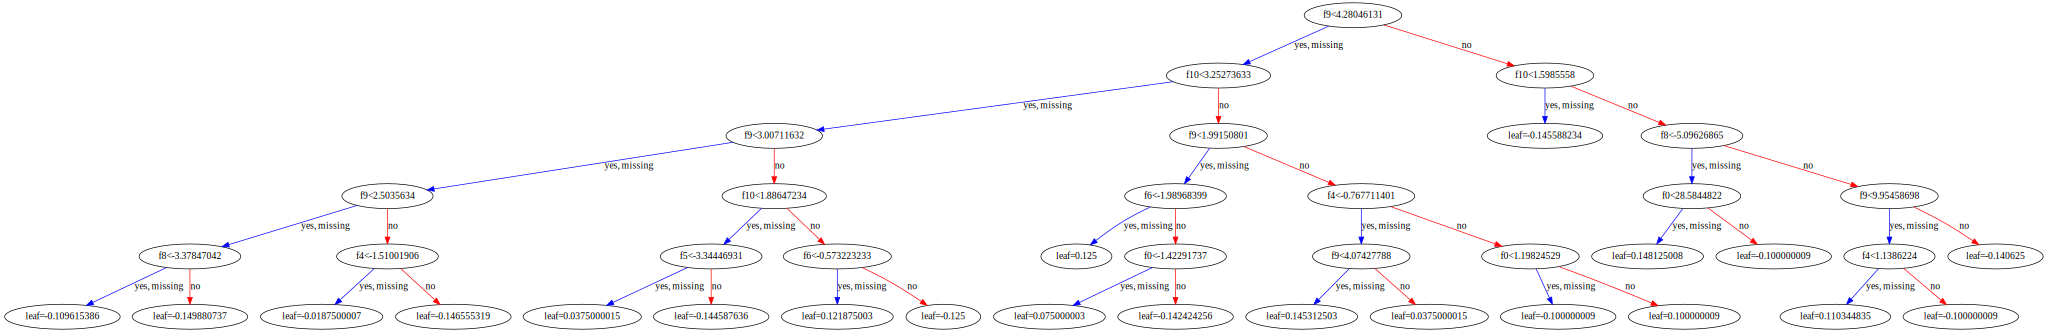

In [0]:
xgb.to_graphviz(bst, num_trees=0)

Features 8, 9, 10 seem to be contributing the most gain according to this XGBoost Model of the principal components. Let's try just working with these three features and the target.

In [0]:
shorter_df = principalDf.iloc[:, -4:]
X, y = split_data_into_feature_and_target(shorter_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Stochastic Gradient Descent (OOTB)

In [0]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0, alpha=0.0001)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(classification_report(y_test, y_pred))
print(f"ROC Score: {roc_auc_score(y_test, y_pred)}")

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00     85299\n'
 '           1       0.84      0.48      0.61       144\n'
 '\n'
 '    accuracy                           1.00     85443\n'
 '   macro avg       0.92      0.74      0.81     85443\n'
 'weighted avg       1.00      1.00      1.00     85443\n')
ROC Score: 0.7395071307987198


In [0]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 85286                   | FP = 13


Actually Fraudulent     | FN = 75                       | TP = 69 


Specificity: 0.4791666666666667
Sensitivity (aka. Recall): 0.9998475949307729


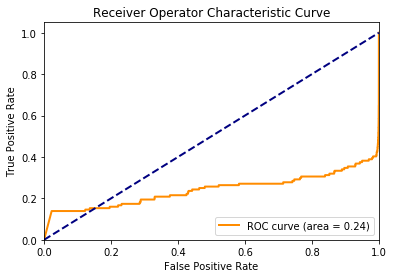

In [0]:
plot_roc(y_test, predict_max_prob(model, X_test))

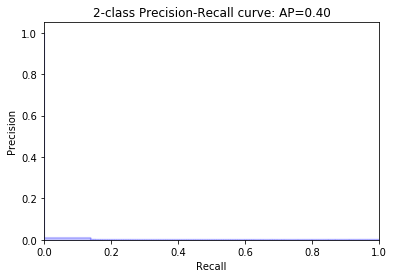

In [0]:
plot_prc(y_test, predict_max_prob(model, X_test), y_pred)

This plot ROC curve is very telling, due to the class imbalance problem inherent to anomaly detection.

### Logistic Regressor

In [0]:
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.1, 0.2, 0.4, 0.6, 1.0]
}

data_blob, fitted_model, elapsed_time = fit_get_predictions_with_CV(data=principalDf, 
                                                                    model_name="logistic regression", 
                                                                    param_search_space=param_grid)

y_pred = data_blob[4]
y_test = data_blob[3]

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

In [0]:
plot_roc(y_test, predicted_max_prob(fitted_model, X_test))

NameError: ignored

In [0]:
plot_prc(y_test, predicted_max_prob(fitted_model, X_test))

### Naive Bayes

In [0]:
naive_bayes_data_bundle, fitted_model, elapsed_time = fit_simple_model(principalDf, "naive bayes")

y_pred = naive_bayes_data_bundle[4]
y_test = naive_bayes_data_bundle[3]

Model fitting and prediction complete.
Elapsed Time: 0.06951685300009558s


In [0]:
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
plot_roc(y_test, y_pred_probs_max)

ValueError: ignored

In [0]:
pp.pprint(classification_report(y_test, y_pred))
print("\n")
print(f"ROC Score: {roc_auc_score(y_test, y_pred)}")
print("Confusion matrix\n{}".format(confusion_matrix(y_test, y_pred)))
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred)}")


('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.98      0.99    113732\n'
 '           1       0.06      0.72      0.11       191\n'
 '\n'
 '    accuracy                           0.98    113923\n'
 '   macro avg       0.53      0.85      0.55    113923\n'
 'weighted avg       1.00      0.98      0.99    113923\n')


ROC Score: 0.8490152425938227
Confusion matrix
[[111543   2189]
 [    54    137]]
Recall: 0.7172774869109948
Precision score: 0.0588993981083405


Due to the class imbalances, the Naive Bayes classifier has a terrible time with retrieving higher precision and true positive rates, which is the key to a successful anomaly detection machine.

### Random Forest Classifier

In [0]:
param_grid = {"n_estimators": [40, 45, 50],
              "max_depth": [5], 
              "min_samples_leaf": [3, 4, 5]}

random_forest_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(principalDf, "RFC", param_grid)

y_pred = random_forest_data_bundle[4]
y_test = random_forest_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 1336.8516822379988s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00     85307\n'
 '           1       0.89      0.57      0.70       136\n'
 '\n'
 '    accuracy                           1.00     85443\n'
 '   macro avg       0.94      0.79      0.85     85443\n'
 'weighted avg       1.00      1.00      1.00     85443\n')


ROC Score: 0.7867060940451063
Confusion matrix
[[85297    10]
 [   58    78]]
Recall: 0.5735294117647058
Precision score: 0.8863636363636364


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.999204,0.886364,0.573529,0.786706,0.499203,1336.8516822379988


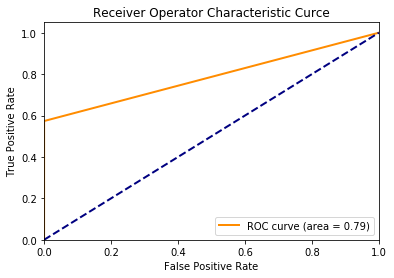

In [0]:
plot_roc(y_test, y_pred)

### Nearest Neighbors

In [0]:
param_grid = {
    "n_neighbors":[5, 6, 7]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(shorter_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 30.145930512000632s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00     85307\n'
 '           1       0.94      0.75      0.83       136\n'
 '\n'
 '    accuracy                           1.00     85443\n'
 '   macro avg       0.97      0.87      0.92     85443\n'
 'weighted avg       1.00      1.00      1.00     85443\n')


ROC Score: 0.8749589717139273


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 85300                   | FP = 7


Actually Fraudulent     | FN = 34                       | TP = 102 


Specificity: 0.75
Sensitivity (aka. Recall): 0.9999179434278547


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.99952,0.93578,0.75,0.874959,0.698049,0.832653,30.145930512000632


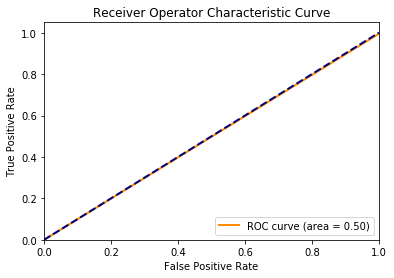

In [0]:
plot_roc(y_test, predict_max_prob(fitted_model, X_test))

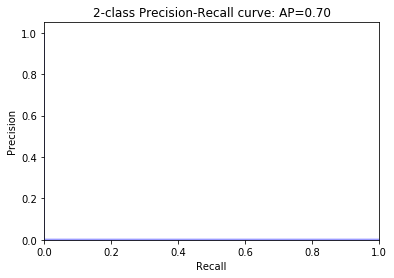

In [0]:
plot_prc(y_test, 
         predict_max_prob(fitted_model, X_test), 
         y_pred)

## Notes

From all these simple models, we can see the same shape over and over again, which indicates a major class imbalance, that is, a very large majority of the cases are the non-fraudulent cases (as expected, vs. fraudlent ones). As we can see, we have an almost perfect accuracy score here and our area under the ROC curve score is good. These are good starts for predictive modeling, however, I think we need to lift our "recall" score, which is probably one of the most important metric here (along side specificity) as those metrics constitute how good we are at detecting the minority fraudulent cases. Again, this is nothing new. Just hammering the same intuition we've seen and experienced time and time again.

Therefore we have to take a different approach to the problem. We will go at it in two approaches here:

1) Outlier Detection/Anomaly detection

2) and Undersampling of the majority class/oversampling of the minority class 

## Addressing Class Imbalance - Down Sampling Majority Class

Another approach to addressing the problem of class imbalance is with down-sampling the majority class. This is something we've done before in a few other problems, and it might not be an option in all the cases. In this case, however, I think we have enough data points in total, and enough cases of the majority class we can down sample from. 

Keep in mind, we want to downsample to include the most influential and representative samples to learn from from the majority negative class. We will be making use of the SMOTE python library and its methods to select an approprirate down-sampling strategy for our problem

### Naive Random Over-resampling of the minority class

One of the easiest strategies, albeit, one of the most naive strategies of over sampling is using random sampling of the minority class to have higher representation in the dataset.

To resample, resampling objects often provide samples of the form:

estimator = obj.fit(data, targets)

data_resampled, targets_resampled = obj.fit_resample(data, targets)

In [0]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0, 284315), (1, 284315)]


In [0]:
ROS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

1.0    284315
0.0    284315
Name: target, dtype: int64

We fit a simple Naive Bayes model with some parameter searching to see how well the model fits to a perfectly balanced, over sampled dataset. We expect much much beter recall and higher F1-scores and higher recall.

In [0]:
param_grid = {
    "n_neighbors":[5, 6, 7]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(ROS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 265.90498992500034s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       1.00      1.00      1.00     85149\n'
 '         1.0       1.00      1.00      1.00     85440\n'
 '\n'
 '    accuracy                           1.00    170589\n'
 '   macro avg       1.00      1.00      1.00    170589\n'
 'weighted avg       1.00      1.00      1.00    170589\n')


ROC Score: 0.9995126190560076
Confusion matrix
[[85066    83]
 [    0 85440]]
Recall: 1.0
Precision score: 0.9990295008360324


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.999513,0.99903,1.0,0.999513,0.998054,0.999515,265.90498992500034


In [0]:
fitted_model.best_params_

{'n_neighbors': 5}

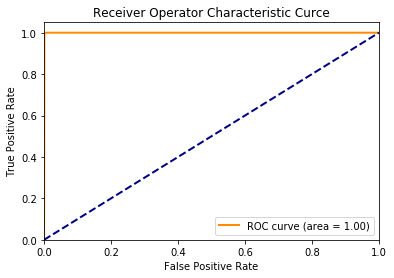

In [0]:
plot_roc(y_test, y_pred)

Verdict: Don't randomly and naively over sample! There is clearly an over fitted model. I wish that big number was a good sign in this case, but clearly, there needs to be some balanced thats struck and this ain't it chief.

### Under Sampling of the Majority Class Naively

This approach reducees the number of majority cases in the dataset to help the decision function learn less about the signals from the majority case and more from that of the minority case. 

Depending on how many minority cases you actually have, this might be a terrible idea, in the most extreme of cases, but we will never know unless we learn and try.

In [0]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 492), (1, 492)]


In [0]:
KMUS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(KMUS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 0.13857404900045367s


In [0]:
fitted_model.best_params_

{'n_neighbors': 4}

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       0.89      0.96      0.93       150\n'
 '         1.0       0.96      0.88      0.92       146\n'
 '\n'
 '    accuracy                           0.92       296\n'
 '   macro avg       0.92      0.92      0.92       296\n'
 'weighted avg       0.92      0.92      0.92       296\n')


ROC Score: 0.9217808219178082


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 144                   | FP = 6


Actually Fraudulent     | FN = 17                       | TP = 129 


Specificity: 0.8835616438356164
Sensitivity (aka. Recall): 0.96


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.922297,0.955556,0.883562,0.921781,0.689132,0.918149,0.13857404900045367


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

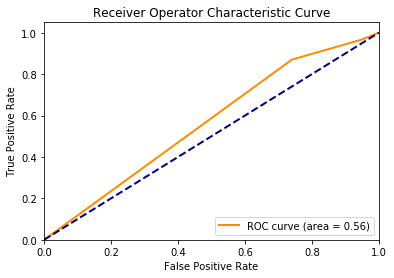

In [0]:
plot_roc(y_test, y_pred_probs_max)

When we plot the probabilities on the ROC curbe, we get a crappy model. When we plot the class predictions themselves, we get something that looks more awesome but incorrect.

We can test this model against randomly sampled non-fraud cases and see how well this model performs.

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

0.0    83564
1.0     1730
dtype: int64

In [0]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 83564                   | FP = 1730


Actually Fraudulent     | FN = 0                       | TP = 0 


Specificity: nan
Sensitivity (aka. Recall): 0.979717213403053


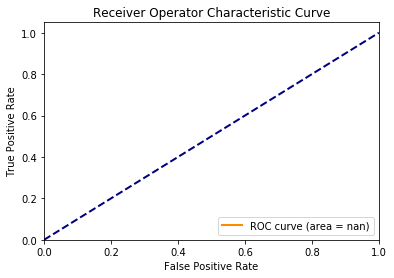

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
print(f"{1753/(1753+83541)} %")

0.020552442141299504 %


There were no fraudulent cases in this step, however, there alarm in the model went off in the cases of 1753 cases, with this type of naive sampling in this instance. This model therefore would cause unncessary harm and arm in its clients 2% of the time, which is too shockingly high of a number. This needs to be lowered because the harm and alarm of false positive cases can be enough for your clients to end their relationship with you.

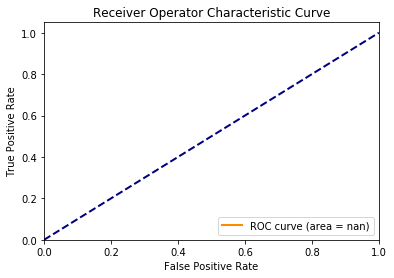

In [0]:
plot_roc(y_test, y_pred)

### Undersampling of majority class with a meta-estimator

With an instance hardness threshold approach, we can use a meta-estimator in the form of a logistic regressor, to filter out noisy examples that do not reach a probability threshold for inclusion in the dataset. This method employs cross validation as well

In [0]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter
iht = InstanceHardnessThreshold(random_state=0,
                                estimator=LogisticRegression(
                                    solver='lbfgs', multi_class='auto'))
X_resampled, y_resampled = iht.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 493), (1, 492)]


In [0]:
IHTUS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(IHTUS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 0.14205102900086786s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.03      0.05     85306\n'
 '           1       0.00      1.00      0.00       136\n'
 '\n'
 '    accuracy                           0.03     85442\n'
 '   macro avg       0.50      0.51      0.03     85442\n'
 'weighted avg       1.00      0.03      0.05     85442\n')


ROC Score: 0.5137563594588892


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 2347                   | FP = 82959


Actually Fraudulent     | FN = 0                       | TP = 136 


Specificity: 1.0
Sensitivity (aka. Recall): 0.027512718917778352


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.029061,0.001637,1.0,0.513756,-609.965134,0.003268,0.14205102900086786


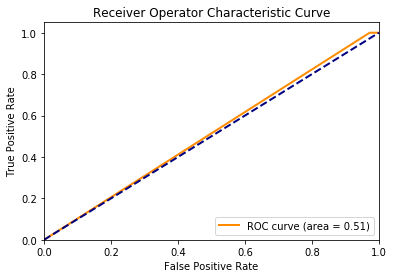

In [0]:
plot_roc(y_test, y_pred)

As we can see, running this sampling method out of the box gives us perfect scores across the board.... WOOHOO! We don't want to be using this type of resampling method because of overfitting, if you cannot tell by the sarcasm. And even if we did, we would have to employ a much more stringent regularization mechanism.

Now we generate samples to test against. Again, no fraudulent cases in this sampling.

In [0]:
X_test, y_test = sample_for_test_set(principalDf, include_minority=True)

In [0]:
y_pred = fitted_model.predict(X_test)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 2503                   | FP = 82787


Actually Fraudulent     | FN = 0                       | TP = 152 


Specificity: 1.0
Sensitivity (aka. Recall): 0.029346933989916755


From the examples that we have above, in general, it seems like undersampling the majority class and castrating essentially the entire dataset (70%), this decision function was not able to learn from enough non-fraud examples and pings for a lot of non-fraud cases as fraud cases. This sampling method seems to probably be the most detrimental to this model, in anycase.

**VERDICT**: we do not use undersampling of the majority with a meta-estimator.

## Undersampling of the Majority Class with OneSidedSelection

In the contrary, OneSidedSelection will use TomekLinks to remove noisy samples [KM1997]. In addition, the 1 nearest neighbor rule is applied to all samples and the one which are misclassified will be added to the set C. No iteration on the set S will take place.

In [0]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 272567), (1, 492)]


In [0]:
OSS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(OSS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 113.29935899099974s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       1.00      1.00      1.00     81781\n'
 '         1.0       0.90      0.77      0.83       137\n'
 '\n'
 '    accuracy                           1.00     81918\n'
 '   macro avg       0.95      0.88      0.91     81918\n'
 'weighted avg       1.00      1.00      1.00     81918\n')


ROC Score: 0.8831383121577057
Confusion matrix
[[81769    12]
 [   32   105]]
Recall: 0.7664233576642335
Precision score: 0.8974358974358975


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.999463,0.897436,0.766423,0.883138,0.678294,0.826772,113.29935899099974


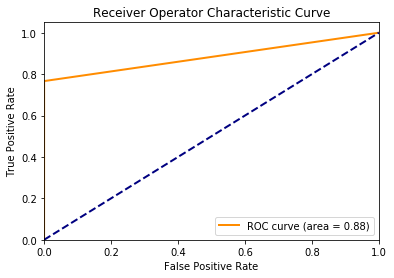

In [0]:
plot_roc(y_test, y_pred)

This method seems like a more balanced approach to undersampling the minority case. We see that we've kept the same number of majority cases somehow, but achieved much better performance with this type of sampling strategy. I've not read in depth about how the sampling strategy employed but I think it will be important to know how it is done. Something about Tomek links.

## Test Modeling against Test dataset (previous majority down sampling)

Create a test data set by resampling a portion of the non-fraud cases and make that the entire test dataset.

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

0.0    85285
1.0        9
dtype: int64

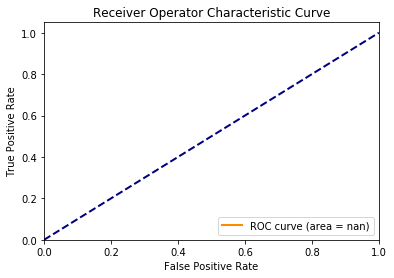

In [0]:
plot_roc(y_test, y_pred)

In [0]:
# Include minority cases in the sampling
X_test, y_test = sample_for_test_set(principalDf, fraction=0.5, include_minority=True)

In [0]:
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

1.0    82939
0.0     2503
dtype: int64

In [0]:
report = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.03      0.06     85290\n'
 '           1       0.00      1.00      0.00       152\n'
 '\n'
 '    accuracy                           0.03     85442\n'
 '   macro avg       0.50      0.51      0.03     85442\n'
 'weighted avg       1.00      0.03      0.06     85442\n')


ROC Score: 0.5146734669949584


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 2503                   | FP = 82787


Actually Fraudulent     | FN = 0                       | TP = 152 


Specificity: 1.0
Sensitivity (aka. Recall): 0.029346933989916755


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.031074,0.001833,1.0,0.514673,-544.621969,0.003659,0.14205102900086786


In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

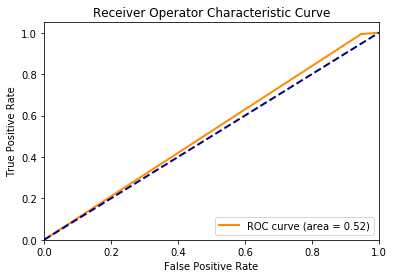

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 85288                   | FN = 5


Actually Fraudulent     | TP = 119                     | FP = 30


Sensitivity: 0.9596774193548387
Specificity or Precision: 0.9996483743172602


# Conclusion of Down Sampling Strategy

Using the OneSideSelection down sampling strategy, fitting a model to this dataset, and then testing on a purely majority-class dataset yields positive expected values (i.e., almost 0 fraudulent cases predicted), meaning that the decision function has learned of some of the patterns for fraudulent activity.

Having a higher Sensitivity score here is important because we want to capture as much of the fraudulent activity as possible, while mitigating the number of missed-detections and the number of false-alarms. In this case, there were 30 missed fraudulent cases that went under the radar and 5 false alarms for the 124 pings for frauduldent activity.

This is a start but this is certainly not good enough. We need to get that False-Positive rate/Missed-Fraudulent number as low as possible.

### Over sampling of the Minority Class

We over sample the minority class to have more examples to learn from, but rather than just randomly doing it, there are some technicality to the approaches that we can choose. I'll go through training a decision function with resampling using two powerful methods offered by the imbalanced-learn library:

1) SMOTE - Synthetic Minority Oversampling Technique

2) ADASYN - Adaptive Synthetic sampling

These two oversampling approaches use methods of interpolation to generate synthetic samples as opposed to the type of sampling done with Random over sampling, which duplicates examples.

Formula for SMOTE sample generation:

![Formula for SMOTE sample generation](https://imbalanced-learn.readthedocs.io/en/stable/_images/math/7d17f8d1d74c655eb15821661276d94c82d0e5b4.png)

Lambda is a value between 0 and 1 and a sample is interpolated along the line between Xi and Xzi.

<br>

![Sampling](https://imbalanced-learn.readthedocs.io/en/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png)



In [0]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 284315), (1, 284315)]


In [0]:
smote_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(smote_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 267.16128286299863s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       1.00      1.00      1.00     85149\n'
 '         1.0       1.00      1.00      1.00     85440\n'
 '\n'
 '    accuracy                           1.00    170589\n'
 '   macro avg       1.00      1.00      1.00    170589\n'
 'weighted avg       1.00      1.00      1.00    170589\n')


ROC Score: 0.9987845236690844


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 84944                   | FP = 205


Actually Fraudulent     | FN = 2                       | TP = 85438 


Specificity: 0.9999765917602996
Sensitivity (aka. Recall): 0.9975924555778694


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.998787,0.997606,0.999977,0.998785,0.995146,0.99879,267.16128286299863


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.3, random_state=42)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

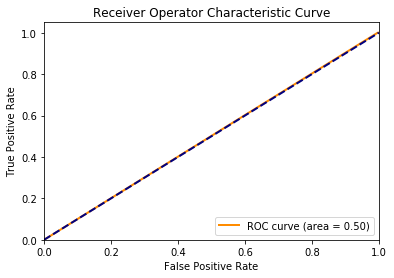

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 284315), (1, 284323)]


In [0]:
adasyn_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(adasyn_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

Training, Validation and Testing are complete.
Elapsed Time: 233.5579051370005s


In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       1.00      1.00      1.00     85199\n'
 '         1.0       1.00      1.00      1.00     85393\n'
 '\n'
 '    accuracy                           1.00    170592\n'
 '   macro avg       1.00      1.00      1.00    170592\n'
 'weighted avg       1.00      1.00      1.00    170592\n')


ROC Score: 0.9987499853284664


                           *Fraudulent Cases are considered Positive Cases
######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########


Actually Non-Fraudulent | TN = 84986                   | FP = 0


Actually Fraudulent     | FN = 213                       | TP = 85393 


Sensitivity (aka. Recall): 0.9975118566455622
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Precision score: 0.9975118566455622


,id,best_parameters,accuracy,precision,recall,roc_auc,r2_score,f1-score,train_time(s)
0,000,<bound method BaseEstimator.get_params of Grid...,0.998751,0.997512,1.0,0.99875,0.995006,0.998754,233.5579051370005


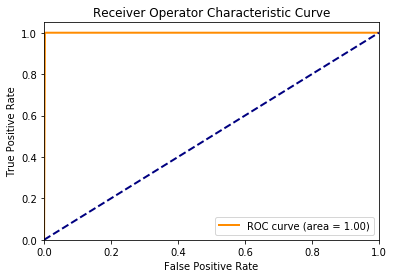

In [0]:
plot_roc(y_test, y_pred)

### Outlier and Novelty Detection

In [0]:
!pip install pyod

In [0]:
# we can do some unsupervised learning targetted around and outlier detection

## Explainablility of the Features for the Predicted Values using LIME